In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import time

# Configure GPU for maximum performance
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU detected: {gpus[0]}")
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected, using CPU")

tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

c:\Users\PC\.conda\envs\tf-gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU memory growth enabled
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070 Ti, compute capability 12.0
Mixed precision enabled


In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize and reshape 
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1) 
x_test = np.expand_dims(x_test, -1)   

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")

def create_data_pipeline(images, labels, batch_size=128, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  
    return dataset

train_dataset = create_data_pipeline(x_train, y_train, batch_size=256, shuffle=True)
val_dataset = create_data_pipeline(x_val, y_val, batch_size=256)
test_dataset = create_data_pipeline(x_test, y_test, batch_size=256)

print("Data pipelines created for optimal GPU utilization")

Training data shape: (54000, 28, 28, 1)
Validation data shape: (6000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Data pipelines created for optimal GPU utilization


In [ ]:
# Define CNN model
def create_advanced_model():
    model = keras.Sequential([
        # First block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax', dtype='float32')  # Output in float32 for stability
    ])
    return model

# Create model
model = create_advanced_model()

initial_learning_rate = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                        

In [ ]:

checkpoint_path = "best_model.weights.h5"

training_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=0,
        profile_batch=0
    )
]

optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Starting training...")
start_time = time.time()

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=training_callbacks,  
    verbose=1
)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print("Loaded best weights from checkpoint")
else:
    print("No checkpoint found, using final weights")

Starting training...
Epoch 1/50
209/211 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9759
Epoch 1: val_accuracy improved from -inf to 0.39300, saving model to best_model.weights.h5
211/211 [==============================] - 4s 14ms/step - loss: 0.0764 - accuracy: 0.9759 - val_loss: 2.7959 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 2/50
209/211 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9849
Epoch 2: val_accuracy improved from 0.39300 to 0.98217, saving model to best_model.weights.h5
211/211 [==============================] - 3s 13ms/step - loss: 0.0484 - accuracy: 0.9849 - val_loss: 0.0672 - val_accuracy: 0.9822 - lr: 0.0010
Epoch 3/50
207/211 [============================>.] - ETA: 0s - loss: 0.0390 - accuracy: 0.9880
Epoch 3: val_accuracy improved from 0.98217 to 0.98883, saving model to best_model.weights.h5
211/211 [==============================] - 3s 13ms/step - loss: 0.0390 - accuracy: 0.9880 - val_loss: 0.0466 - val_accurac

Test accuracy: 0.9952
Test Accuracy: 0.9952


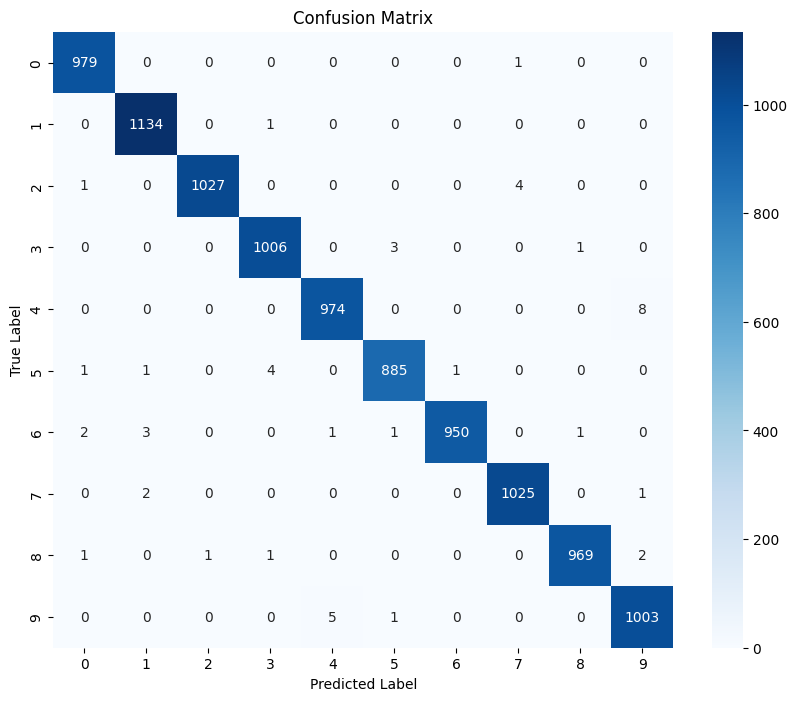

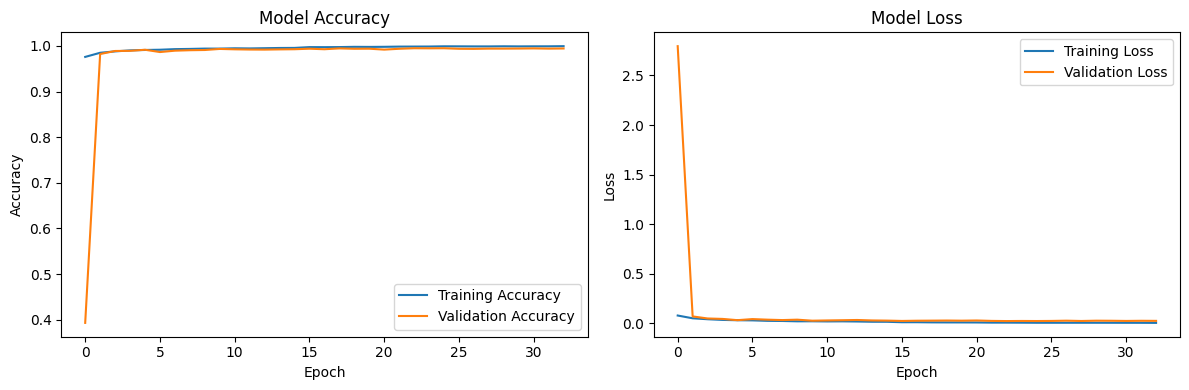

Model saved as mnist_cnn_advanced.h5


In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_pred = model.predict(test_dataset, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

test_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the model
model.save('mnist_cnn_advanced.h5')
print("Model saved as mnist_cnn_advanced.h5")